In [1]:
!kaggle datasets download rawsi18/military-assets-dataset-12-classes-yolo8-format

Dataset URL: https://www.kaggle.com/datasets/rawsi18/military-assets-dataset-12-classes-yolo8-format
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 3.81G/3.83G [00:38<00:00, 185MB/s]
100% 3.83G/3.83G [00:38<00:00, 107MB/s]


In [2]:
import zipfile
with zipfile.ZipFile('military-assets-dataset-12-classes-yolo8-format.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
    zip_ref.close()

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 43.6 MB/s eta 0:00:00


In [5]:
!pip install wandb

In [6]:
train_path = '/content/data/military_object_dataset/train'
val_path = '/content/data/military_object_dataset/val'
test_path = '/content/data/military_object_dataset/test'

In [7]:
import os
import pandas as pd
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import ultralytics
from ultralytics import YOLO
import numpy as np
import random

#tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import *
import keras_cv

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import seaborn as sns

#
import wandb
wandb.init(mode="disabled")
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
train_images = os.listdir(train_path+'/images')
test_images = os.listdir(test_path+'/images')
val_images = os.listdir(val_path+'/images')
train_labels = os.listdir(train_path+'/labels')
test_labels = os.listdir(test_path+'/labels')
val_labels = os.listdir(val_path+'/labels')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_val_images = len(val_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)
num_val_labels = len(val_labels)

print('images train: ',num_train_images,', images test: ', num_test_images,', images val: ', num_val_images, )
print('labels train: ',num_train_labels,', labels test: ', num_test_labels,', labels val: ', num_val_labels, )

images train:  21978 , images test:  1396 , images val:  2941
labels train:  21978 , labels test:  1396 , labels val:  2941


In [9]:
def train_val_generators(train_dir, validation_dir, test_dir):
  train_datagen = ImageDataGenerator(rescale=1./255.)

  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))
  validation_datagen = ImageDataGenerator(rescale=1./255.)
  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))
  test_datagen = ImageDataGenerator(rescale=1./255.)
  test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))
  return train_generator, validation_generator, test_generator

In [10]:
training_dir='/content/data/military_object_dataset/train'
validation_dir='/content/data/military_object_dataset/val'
test_dir='/content/data/military_object_dataset/test'
train_generator, validation_generator, test_generator = train_val_generators(training_dir, validation_dir, test_dir)

Found 21978 images belonging to 2 classes.
Found 2941 images belonging to 2 classes.
Found 1396 images belonging to 2 classes.


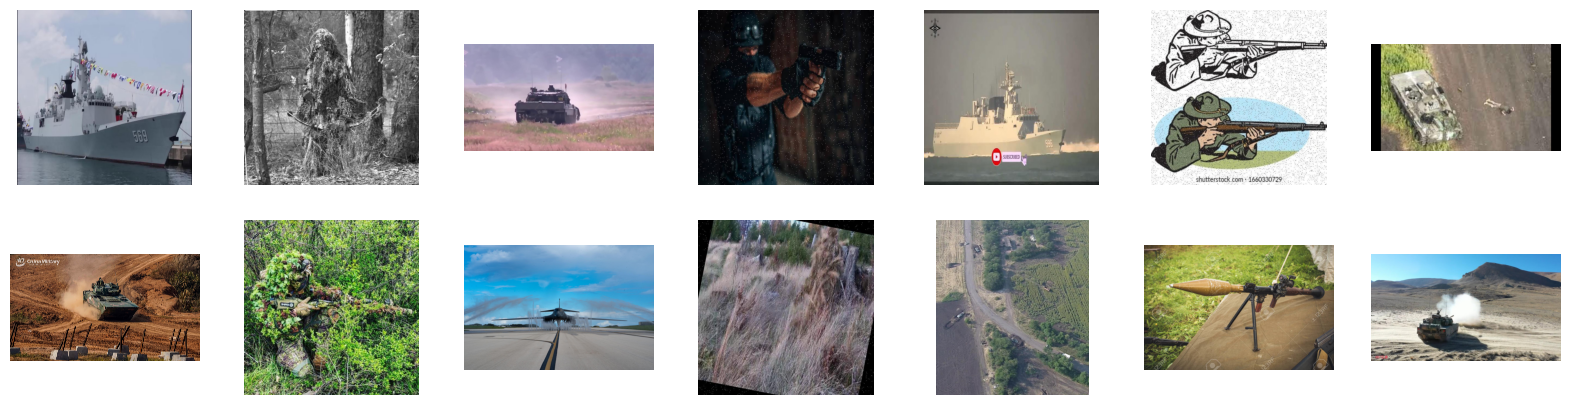

In [11]:
plt.figure(figsize=(20, 5))
for i,c in enumerate(np.random.randint(0,len(train_images),size=14),start=1):
  plt.subplot(2,7,i)
  # im=plt.imshow(mpimg.imread(train_path+'/images/'+train_images[c])) # Removed this line
  # plt.imshow(im , cmap='gray') # Removed this line
  # Directly display the image using mpimg.imread with cmap='gray'
  plt.imshow(mpimg.imread(train_path+'/images/'+train_images[c]), cmap='gray')
  plt.axis('off')
plt.show()

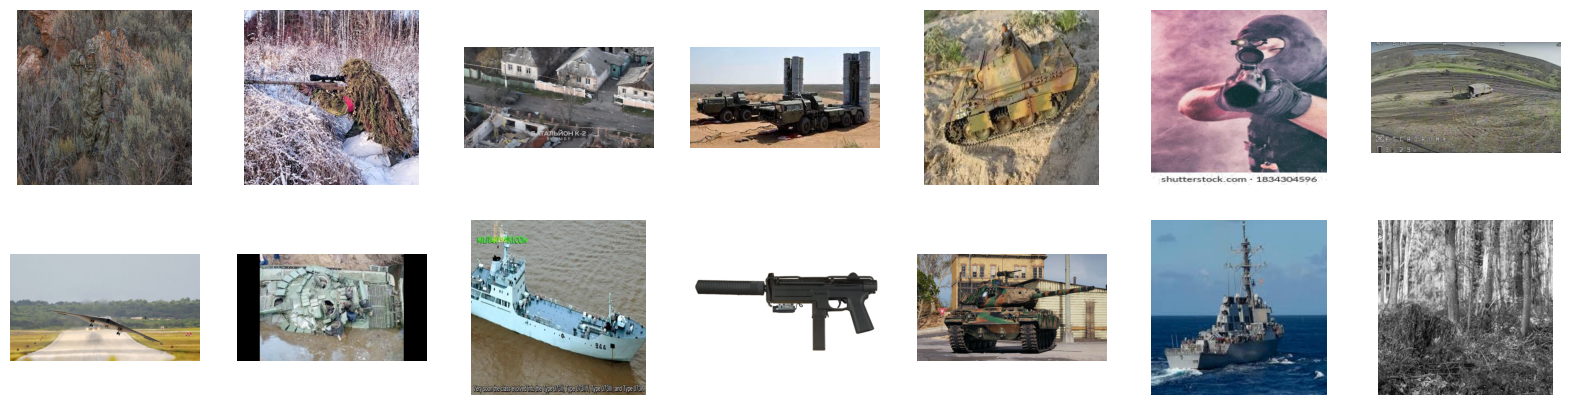

In [12]:
plt.figure(figsize=(20, 5))
for i,c in enumerate(np.random.randint(0,len(val_images),size=14),start=1):
  plt.subplot(2,7,i)
  # im=plt.imshow(mpimg.imread(train_path+'/images/'+train_images[c])) # Removed this line
  # plt.imshow(im , cmap='gray') # Removed this line
  # Directly display the image using mpimg.imread with cmap='gray'
  plt.imshow(mpimg.imread(val_path+'/images/'+val_images[c]), cmap='gray')
  plt.axis('off')
plt.show()

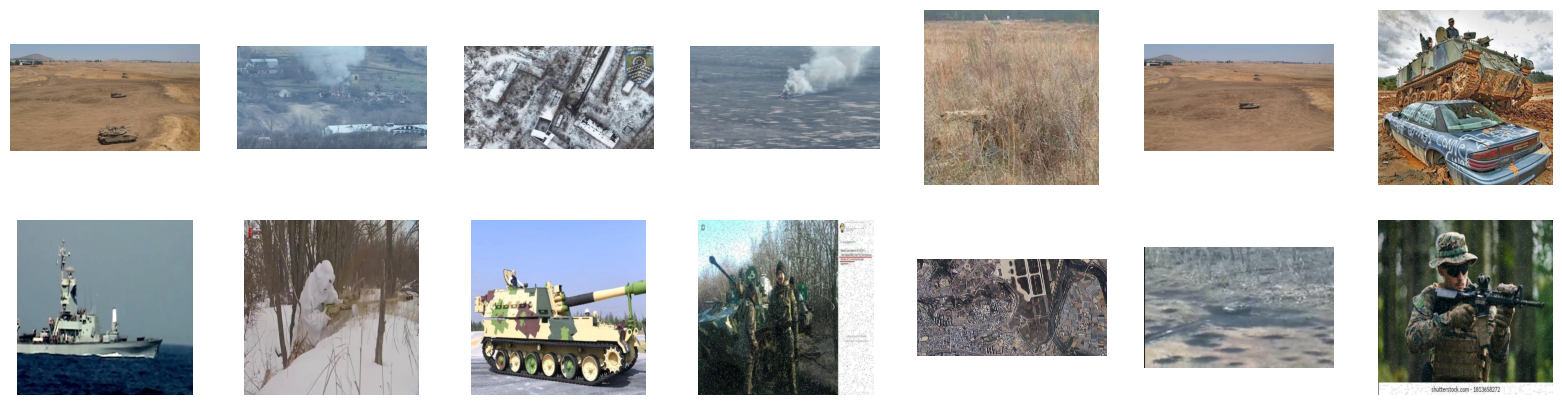

In [13]:
plt.figure(figsize=(20, 5))
for i,c in enumerate(np.random.randint(0,len(test_images),size=14),start=1):
  plt.subplot(2,7,i)
  # im=plt.imshow(mpimg.imread(train_path+'/images/'+train_images[c])) # Removed this line
  # plt.imshow(im , cmap='gray') # Removed this line
  # Directly display the image using mpimg.imread with cmap='gray'
  plt.imshow(mpimg.imread(test_path+'/images/'+test_images[c]), cmap='gray')
  plt.axis('off')
plt.show()

In [14]:
model=YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 115MB/s]


In [16]:
results=model.train(data=('/content/data/military_object_dataset/military_dataset.yaml'),epochs=20, imgsz=640, batch=16,lr0=0.01, lrf=0.1,save_period=1)

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/military_object_dataset/military_dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

100%|██████████| 755k/755k [00:00<00:00, 20.0MB/s]


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 110MB/s]


AMP: checks passed ✅


train: Scanning /content/data/military_object_dataset/train/labels... 21978 images, 294 backgrounds, 0 corrupt: 100%|██████████| 21978/21978 [00:42<00:00, 517.84it/s]


train: New cache created: /content/data/military_object_dataset/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 22, len(boxes) = 43336. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/data/military_object_dataset/val/labels... 2941 images, 273 backgrounds, 0 corrupt: 100%|██████████| 2941/2941 [00:06<00:00, 462.39it/s]

val: New cache created: /content/data/military_object_dataset/val/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.96G      1.311      2.336      1.412         91        640: 100%|██████████| 1374/1374 [08:24<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:41<00:00,  2.24it/s]


                   all       2941       5081      0.625      0.313       0.29      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.86G      1.336      1.716      1.421         41        640: 100%|██████████| 1374/1374 [08:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:41<00:00,  2.23it/s]


                   all       2941       5081      0.304      0.343      0.302      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.54G      1.341      1.589      1.422         26        640: 100%|██████████| 1374/1374 [08:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:41<00:00,  2.22it/s]


                   all       2941       5081      0.511      0.309      0.311      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.75G      1.321      1.493      1.403         31        640: 100%|██████████| 1374/1374 [08:23<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]


                   all       2941       5081      0.485      0.359      0.334      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.87G      1.282      1.406       1.38         31        640: 100%|██████████| 1374/1374 [08:32<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:40<00:00,  2.25it/s]


                   all       2941       5081      0.564      0.354      0.363       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.8G       1.25       1.34      1.359         50        640: 100%|██████████| 1374/1374 [08:54<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:43<00:00,  2.13it/s]


                   all       2941       5081      0.617      0.376       0.41      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.61G      1.231      1.283       1.35         47        640: 100%|██████████| 1374/1374 [08:41<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:44<00:00,  2.06it/s]


                   all       2941       5081      0.572      0.421      0.438      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.47G       1.21      1.237      1.328         52        640: 100%|██████████| 1374/1374 [08:57<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:40<00:00,  2.30it/s]


                   all       2941       5081      0.601      0.425      0.434      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.75G      1.194      1.202       1.32         39        640: 100%|██████████| 1374/1374 [08:45<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:57<00:00,  1.61it/s]


                   all       2941       5081      0.596      0.424      0.469      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.58G      1.172      1.154      1.304         41        640: 100%|██████████| 1374/1374 [08:50<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:37<00:00,  2.44it/s]


                   all       2941       5081      0.606      0.425      0.474      0.303
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.82G      1.141      1.023      1.318         15        640: 100%|██████████| 1374/1374 [07:55<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:37<00:00,  2.47it/s]


                   all       2941       5081      0.594      0.448      0.479      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.6G      1.115       0.97      1.299         23        640: 100%|██████████| 1374/1374 [07:47<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:34<00:00,  2.63it/s]


                   all       2941       5081      0.599      0.453      0.492      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.78G      1.096     0.9326      1.285         19        640: 100%|██████████| 1374/1374 [07:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:35<00:00,  2.56it/s]


                   all       2941       5081      0.615      0.456      0.507      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.46G      1.073     0.9006       1.27         25        640: 100%|██████████| 1374/1374 [07:40<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:35<00:00,  2.60it/s]


                   all       2941       5081      0.618      0.481      0.512      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.74G      1.057     0.8686      1.261         18        640: 100%|██████████| 1374/1374 [07:42<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:35<00:00,  2.59it/s]


                   all       2941       5081      0.648      0.461      0.509      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.65G      1.038     0.8374      1.246         23        640: 100%|██████████| 1374/1374 [07:38<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:35<00:00,  2.61it/s]

                   all       2941       5081      0.657      0.473      0.531      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.51G      1.025     0.8122      1.238         28        640: 100%|██████████| 1374/1374 [07:43<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:36<00:00,  2.54it/s]


                   all       2941       5081      0.654      0.463      0.527      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.92G      1.003     0.7857      1.221         22        640: 100%|██████████| 1374/1374 [07:42<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:35<00:00,  2.59it/s]


                   all       2941       5081      0.663      0.487      0.537      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.89G     0.9928     0.7644      1.212         23        640: 100%|██████████| 1374/1374 [07:37<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:35<00:00,  2.60it/s]


                   all       2941       5081       0.66      0.489      0.545      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.73G     0.9775     0.7445      1.201         28        640: 100%|██████████| 1374/1374 [07:42<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:35<00:00,  2.59it/s]

                   all       2941       5081      0.658      0.486      0.548      0.363



20 epochs completed in 2.962 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 92/92 [00:38<00:00,  2.39it/s]


                   all       2941       5081      0.657      0.487      0.548      0.363
    camouflage_soldier        385        510      0.774      0.712      0.788       0.44
                weapon        222        358      0.738      0.557       0.62      0.455
         military_tank        938       1787      0.821      0.855       0.87      0.597
        military_truck         84        148      0.592      0.589      0.629      0.406
      military_vehicle        149        307      0.648      0.515      0.597      0.439
              civilian          1          1          1          0          0          0
               soldier        420        745      0.835      0.636      0.755       0.45
      civilian_vehicle         18         42      0.357      0.262      0.356      0.192
    military_artillery         85        117      0.564      0.421      0.531      0.329
                trench          1          3          0          0          0          0
     military_aircraf

In [17]:
model.save("military-assets-dataset-12-classes-yolo8-format_model.pt")

In [18]:
import cv2

In [19]:
image_input=cv2.imread('/content/data/military_object_dataset/test/images/002825.jpg')

In [20]:
results = model.predict(source=image_input,conf=0.25,save=True)


0: 640x640 1 camouflage_soldier, 9.1ms
Speed: 3.8ms preprocess, 9.1ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train22


In [21]:
results[0].boxes.xyxy

tensor([[ 38.8537, 135.4330, 279.4753, 576.2527]], device='cuda:0')

In [22]:
results[0].boxes.conf

tensor([0.8775], device='cuda:0')

In [23]:
results[0].boxes.cls

tensor([0.], device='cuda:0')

In [24]:
classNames = ['camouflage_soldier','weapon','military_tank','military_truck','military_vehicle','civilian','soldier','civilian_vehicle','military_artillery','trench',' military_aircraft',' military_warship']

In [25]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [26]:
!pip install cvzone
!pip install opencv-python

  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26298 sha256=f22b7b08f8a6696ac8cf9679879ff18ba9ea1c52a00d0b524d43b5f1577ac281
  Stored in directory: /root/.cache/pip/wheels/ab/36/ec/47be2d4e59dc4289e684d5b0dde54d1e72e51a614e57690e85
Successfully built cvzone


In [27]:
import cv2
import cvzone
import math
from IPython.display import Image

In [28]:
results = model(image_input, stream=True)
for r in results:
    boxes = r.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        w, h = x2-x1, y2-y1
        cvzone.cornerRect(image_input, (x1, y1, w, h))

        conf = math.ceil((box.conf[0]*100))/100

        cls = box.cls[0]
        name = classNames[int(cls)]

        cvzone.putTextRect(image_input, f'{name} 'f'{conf}', (max(0,x1), max(35,y1)), scale = 0.5)

cv2.imwrite('output.jpg', image_input)


0: 640x640 1 camouflage_soldier, 18.3ms
Speed: 3.3ms preprocess, 18.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


True

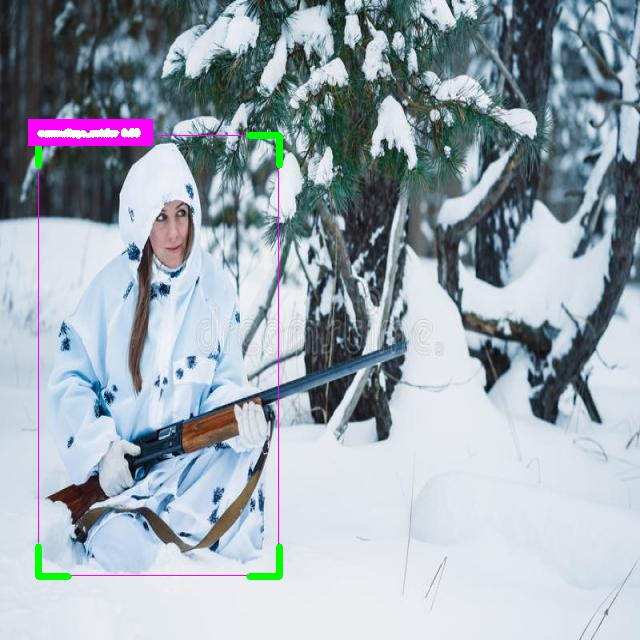

In [29]:
Image("/content/output.jpg")

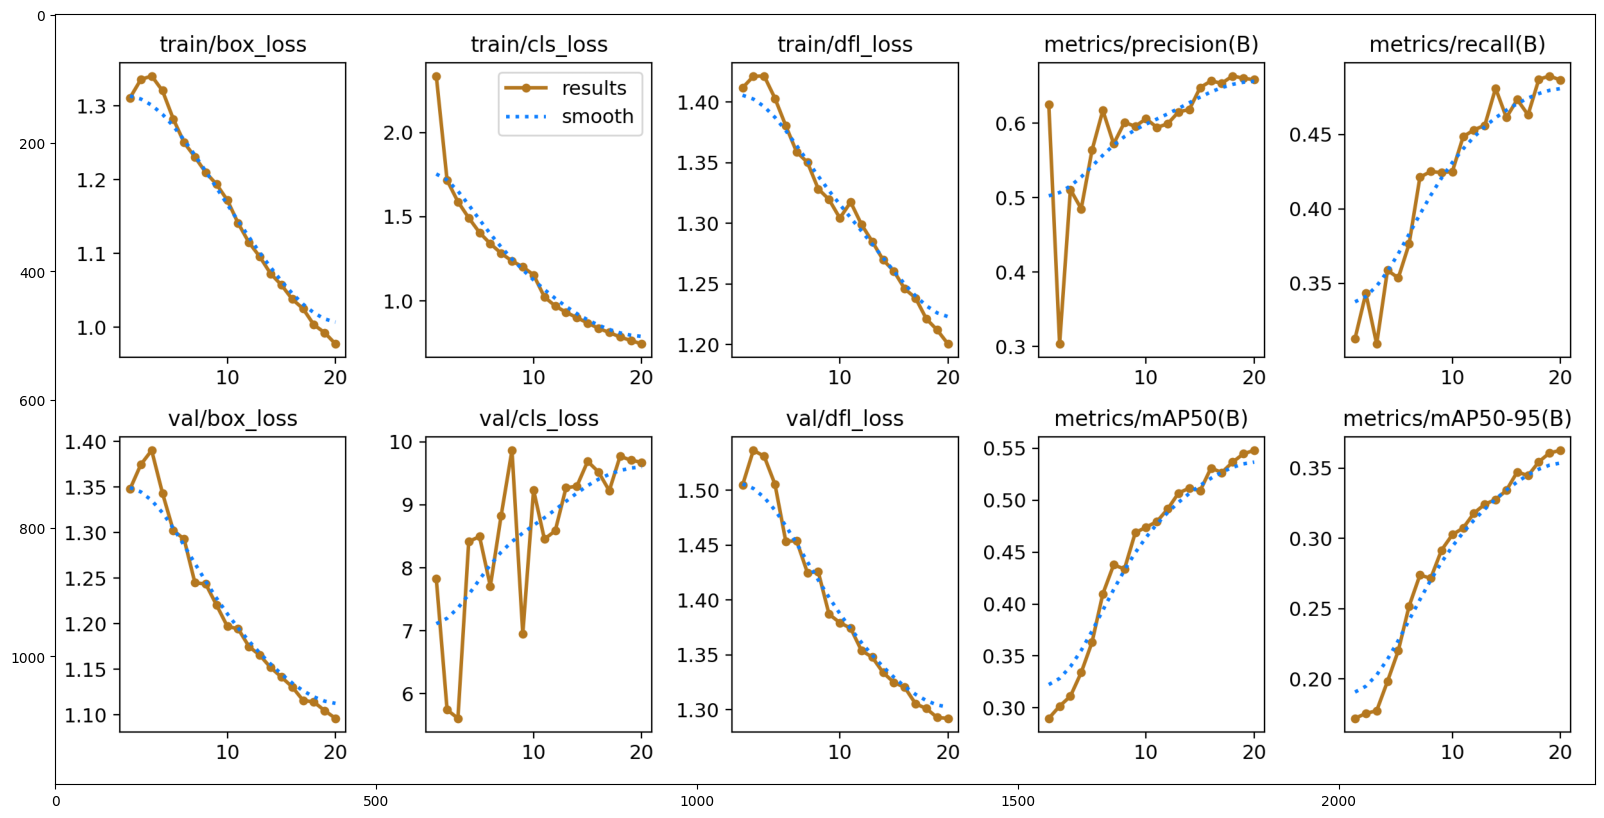

In [30]:
plt.figure(figsize=(20, 10))
img = cv2.imread('/content/runs/detect/train2/results.png')
plt.imshow(img)
plt.show()

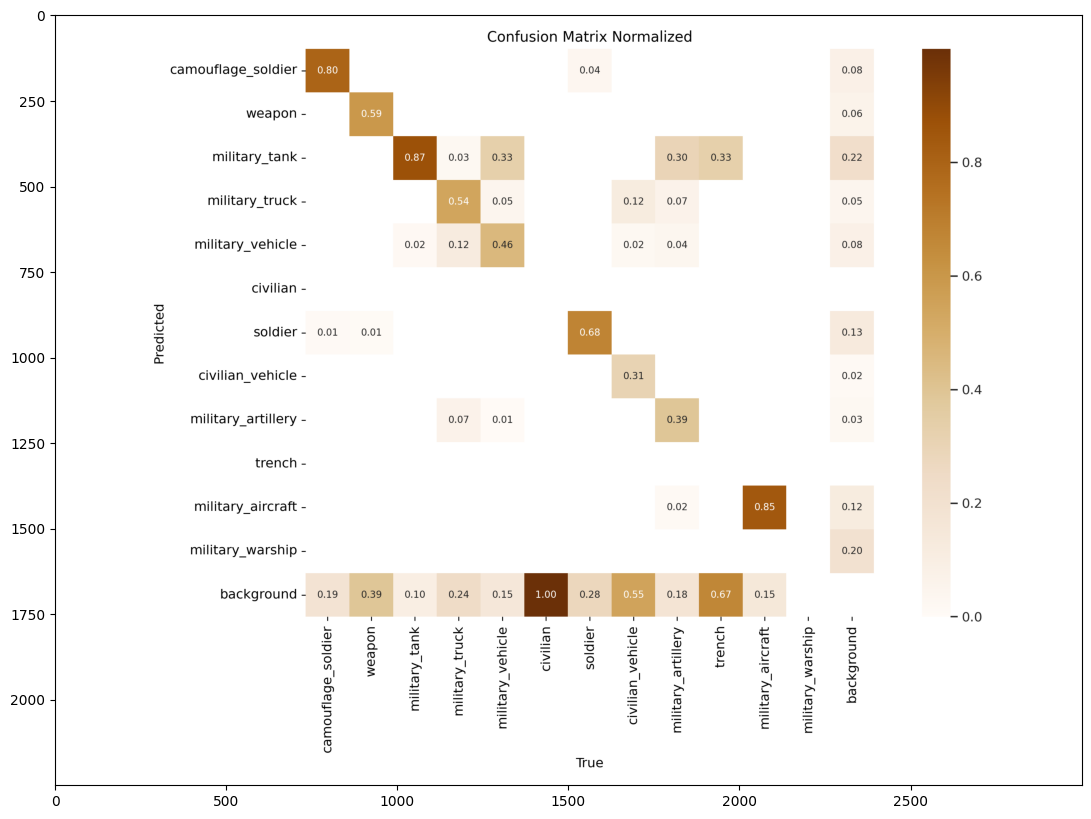

In [31]:
plt.figure(figsize=(20, 10))
img = cv2.imread('/content/runs/detect/train2/confusion_matrix_normalized.png')
plt.imshow(img)
plt.show()

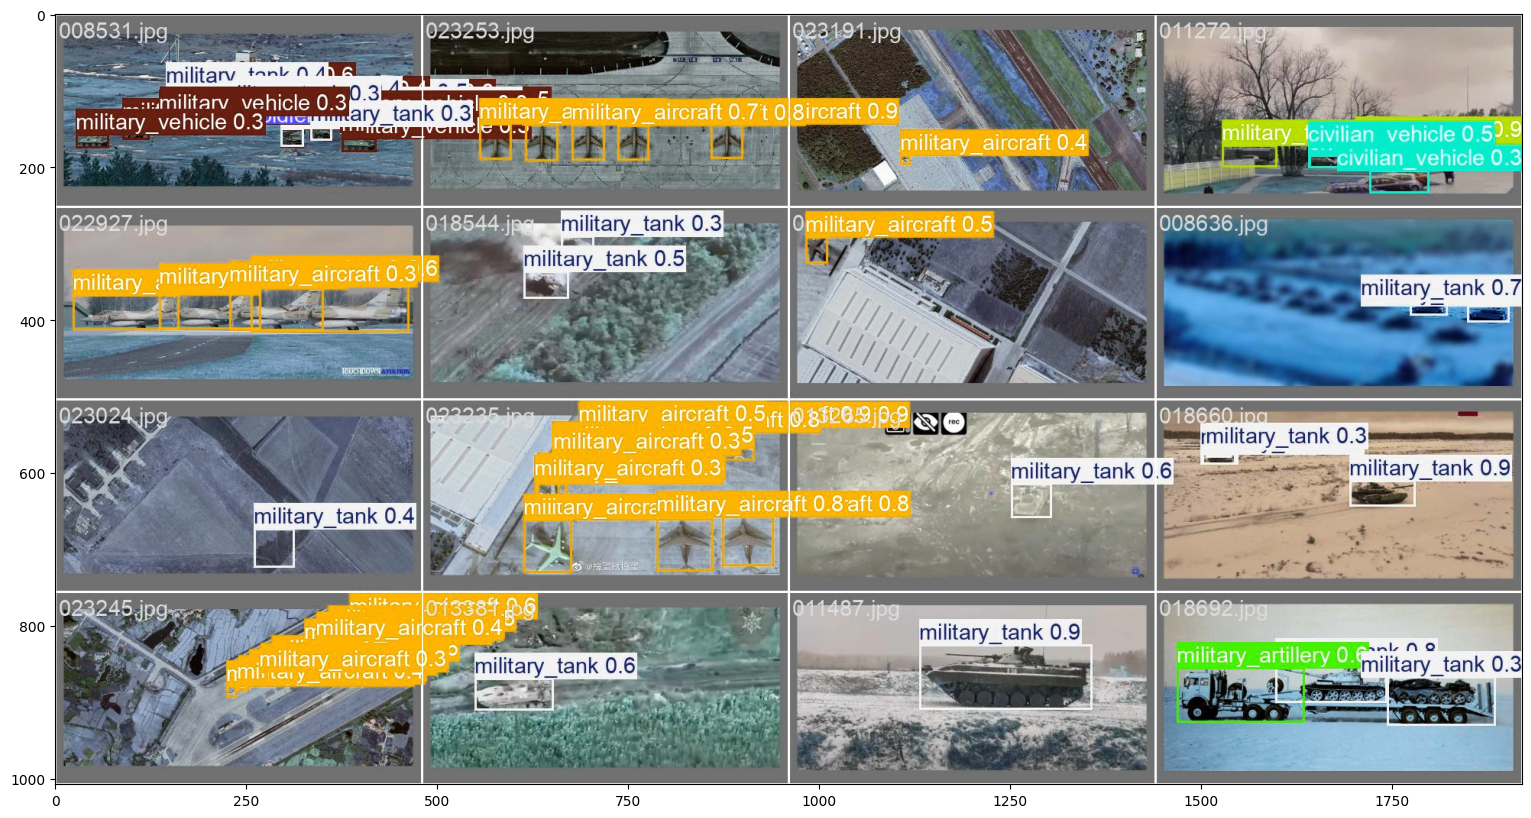

In [32]:
plt.figure(figsize=(20, 10))
img = cv2.imread('/content/runs/detect/train2/val_batch1_pred.jpg')
plt.imshow(img)
plt.show()

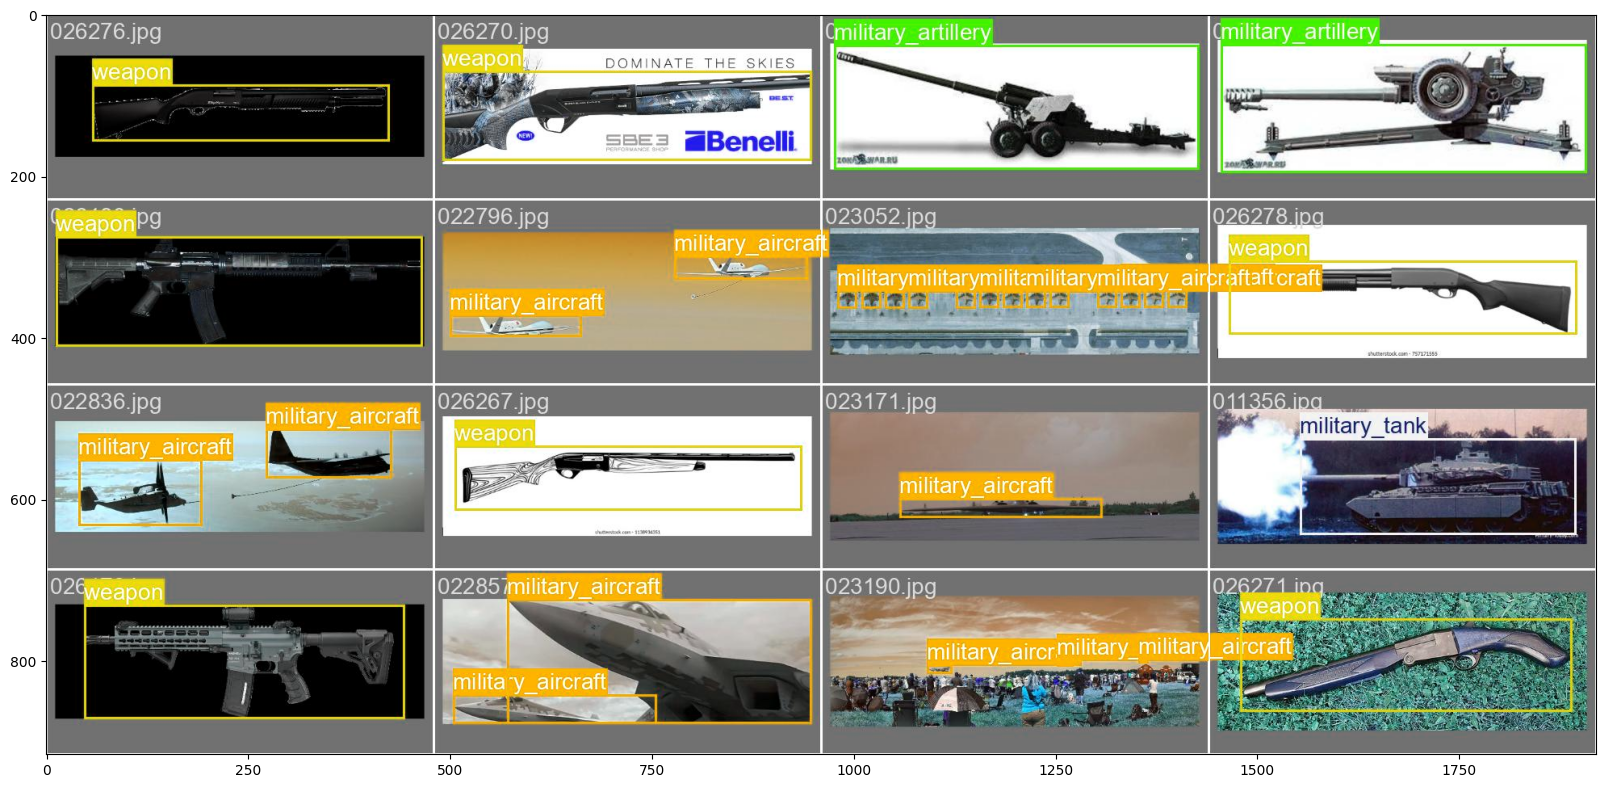

In [33]:
plt.figure(figsize=(20, 10))
img = cv2.imread('/content/runs/detect/train2/val_batch0_labels.jpg')
plt.imshow(img)
plt.show()

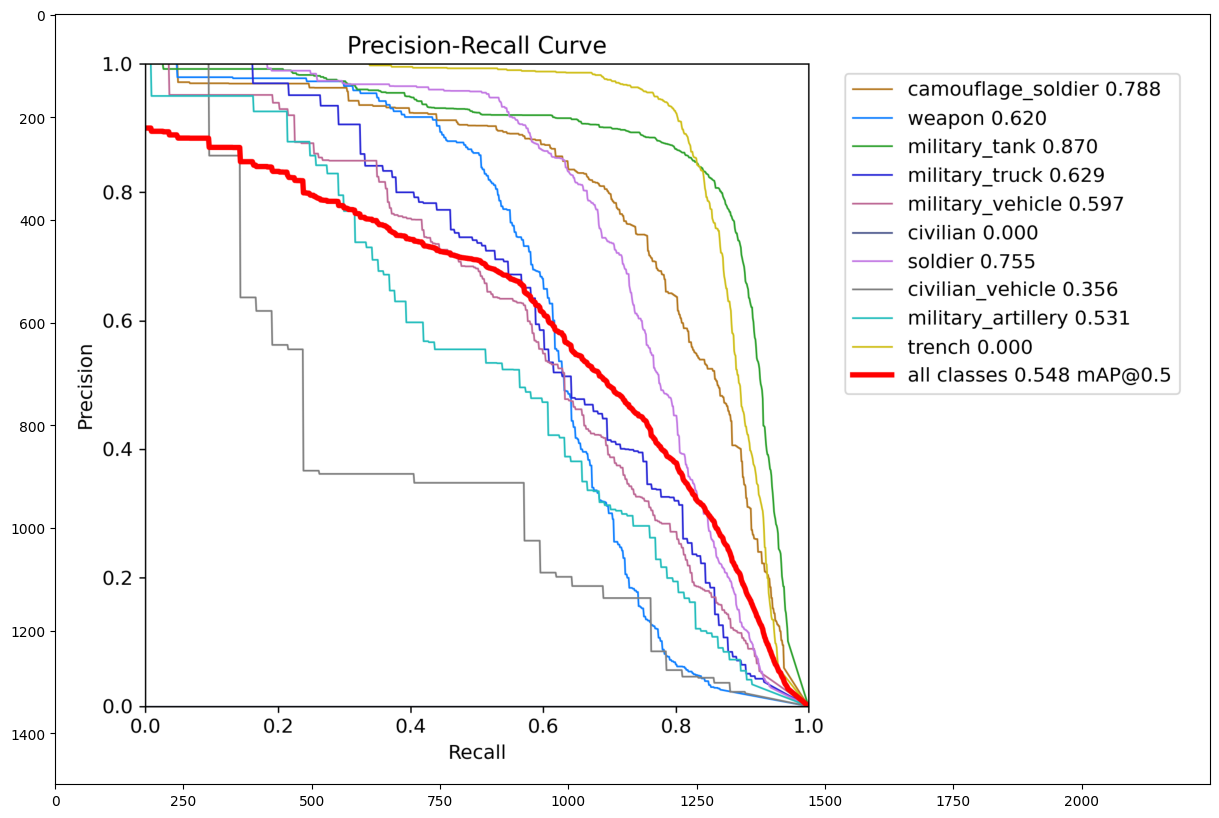

In [34]:
plt.figure(figsize=(20, 10))
img = cv2.imread('/content/runs/detect/train2/PR_curve.png')
plt.imshow(img)
plt.show()

In [35]:
def military_assets(img_path):

    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()

    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img

In [36]:
import random


0: 512x640 1 military_tank, 3 military_trucks, 2 military_vehicles, 1 soldier, 40.2ms
Speed: 3.1ms preprocess, 40.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 1 military_tank, 8.2ms
Speed: 3.4ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 51.5ms
Speed: 2.4ms preprocess, 51.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 5 military_warships, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 military_tank, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 camouflage_soldier, 1 soldier, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 soldiers, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1

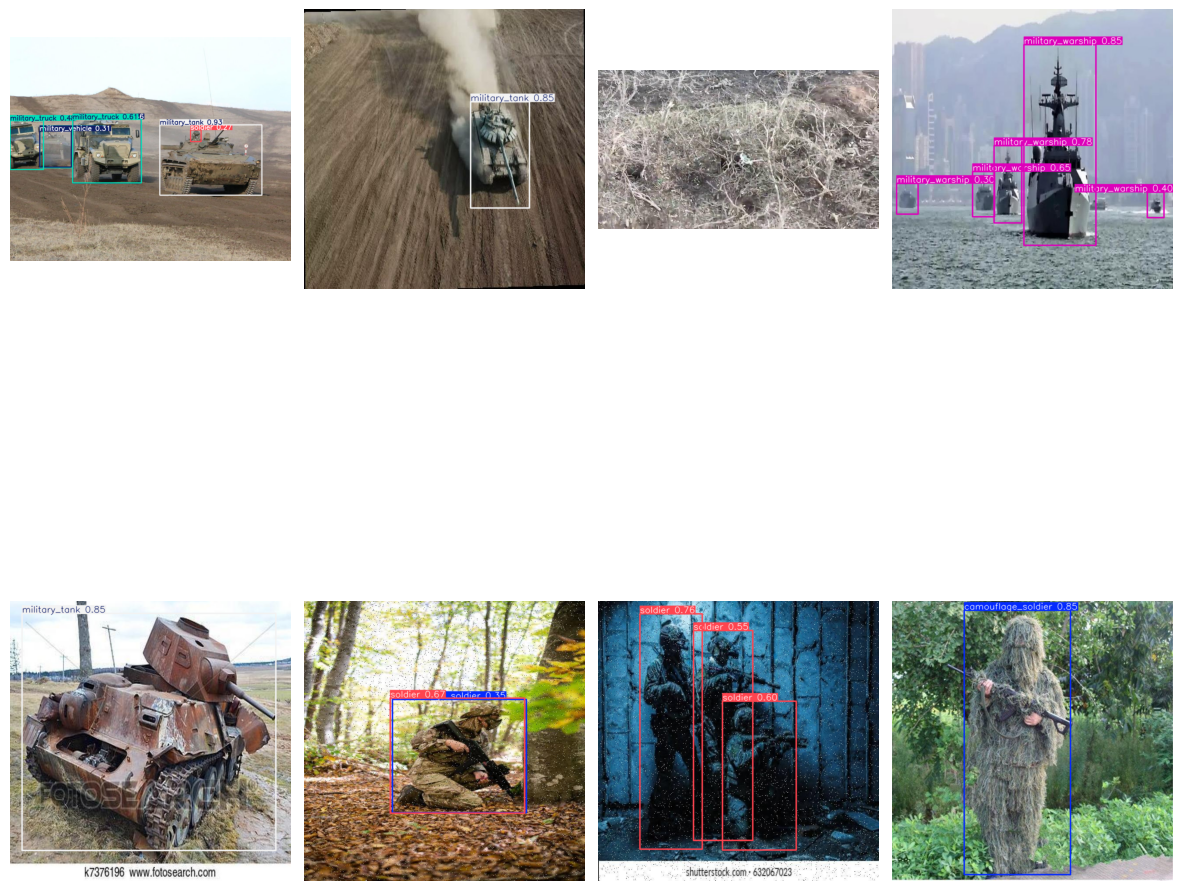

In [37]:
custom_image_dir = '/content/data/military_object_dataset/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 8)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):

    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4

    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = military_assets(img_path)

    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)